In [1]:
!pip install pyvista panel -q
!pip install -q piglet pyvirtualdisplay

In [6]:
import dolfinx
print(f"DOLFINx version: {dolfinx.__version__} is installed")

DOLFINx version: 0.3.1.0 is installed


In [7]:
import dolfinx
import numpy as np
import ufl

from petsc4py import PETSc
from mpi4py import MPI

# Define dimensions of beam:
L = 20.0
W = 5.0

# Define number of elements in each dimension:
NL = 20
NW = 5

mesh = dolfinx.BoxMesh(MPI.COMM_WORLD,[[0.0,0.0,0.0], [L, W, W]], [NL, NW, NW], dolfinx.cpp.mesh.CellType.hexahedron)
V = dolfinx.VectorFunctionSpace(mesh, ("CG", 2))

In [8]:
def left(x):
    return np.isclose(x[0], 0)

def right(x):
    return np.isclose(x[0], L)

left_facets = dolfinx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, left)
right_facets = dolfinx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, right)

In [9]:
# Concatenate and sort the arrays based on facet indices. Left facets marked with 1, right facets with two
marked_facets = np.hstack([left_facets, right_facets])
marked_values = np.hstack([np.full(len(left_facets), 1, dtype=np.int32), np.full(len(right_facets), 2, dtype=np.int32)])
sorted_facets = np.argsort(marked_facets)
facet_tag = dolfinx.MeshTags(mesh, mesh.topology.dim-1, marked_facets[sorted_facets], marked_values[sorted_facets])

In [10]:
u_bc = dolfinx.Function(V)
with u_bc.vector.localForm() as loc:
    loc.set(0)

In [11]:
left_dofs = dolfinx.fem.locate_dofs_topological(V, facet_tag.dim, facet_tag.indices[facet_tag.values==1])
bcs = [dolfinx.DirichletBC(u_bc, left_dofs)]

In [12]:
B = dolfinx.Constant(mesh, (0, 0, 0))
T = dolfinx.Constant(mesh, (0, 0, 0))

In [13]:
v = ufl.TestFunction(V)
u = dolfinx.Function(V)

In [14]:
# Spatial dimension
d = len(u)

# Identity tensor
I = ufl.variable(ufl.Identity(d))

# Deformation gradient
F = ufl.variable(I + ufl.grad(u))

# Right Cauchy-Green tensor
C = ufl.variable(F.T * F)

# Invariants of deformation tensors
Ic = ufl.variable(ufl.tr(C))
J  = ufl.variable(ufl.det(F))

In [15]:
# Elasticity parameters
E, nu = 1.0e4, 0.3
mu = dolfinx.Constant(mesh, E/(2*(1 + nu)))
lmbda = dolfinx.Constant(mesh, E*nu/((1 + nu)*(1 - 2*nu)))
# Stored strain energy density (compressible neo-Hookean model)
psi = (mu / 2) * (Ic - 3) - mu * ufl.ln(J) + (lmbda / 2) * (ufl.ln(J))**2
# Stress
# Hyper-elasticity
P = ufl.diff(psi, F)

In [16]:
metadata = {"quadrature_degree": 4}
ds = ufl.Measure('ds', subdomain_data=facet_tag, metadata=metadata)
dx = ufl.Measure("dx", metadata=metadata)
# Define form F (we want to find u such that F(u) = 0)
F = ufl.inner(ufl.grad(v), P)*dx - ufl.inner(v, B)*dx - ufl.inner(v, T)*ds(2) 

In [17]:
problem = dolfinx.fem.NonlinearProblem(F, u, bcs)

In [18]:
solver = dolfinx.NewtonSolver(MPI.COMM_WORLD, problem)

# Set Newton solver options
solver.atol = 1e-8
solver.rtol = 1e-8
solver.convergence_criterion = "incremental"

  warnings.warn("Plotting of higher order functions is experimental.")


Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'



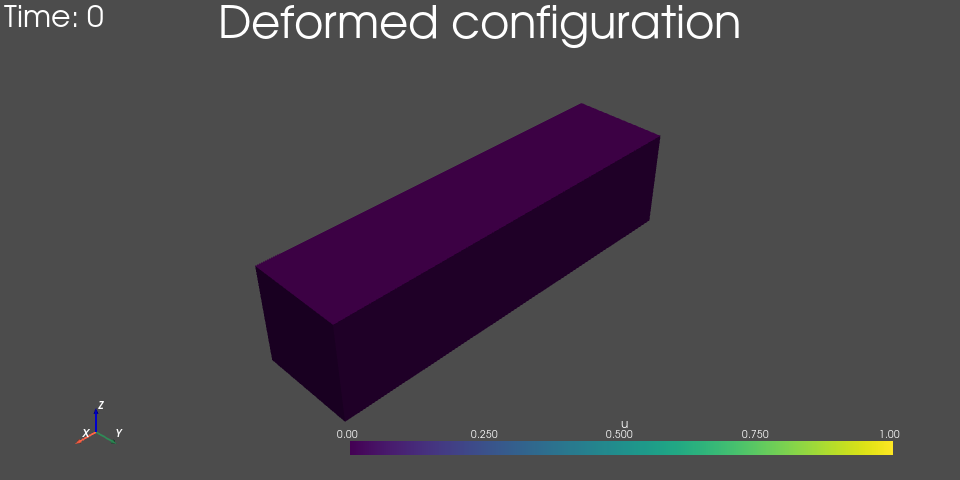

In [19]:
import pyvista
import dolfinx.plot
# Activate framebuffer, required for visualziation
pyvista.start_xvfb(wait=0.05)
# Create background plotter and mesh to attach values to
topology, cell_types = dolfinx.plot.create_vtk_topology(mesh, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)
def plot_function(t, uh):
    """
    Create a figure of the concentration uh warped visualized in 3D at timet step t.
    """
    p = pyvista.Plotter(window_size=[960,480])
    # Add time-stamp
    p.add_text(f"Time: {t}", font_size=12, name="timelabel")
    p.add_text("Deformed configuration", name="title", position="upper_edge")
   
    # Update point values on pyvista grid

    topology, cell_types = dolfinx.plot.create_vtk_topology(V)
     # We create a geometry for our modified mesh using the dof coordinates
    geometry = V.tabulate_dof_coordinates()
    # As we are dealing with a vector field, we reshape the underlying dof array to accommedate for the three dimensional space
    num_dofs = V.dofmap.index_map.size_local + V.dofmap.index_map.num_ghosts
    values = np.zeros((num_dofs, 3), dtype=np.float64)
    values[:, :mesh.geometry.dim] = uh.x.array.real.reshape(num_dofs, V.dofmap.index_map_bs)

    # Create grid defined by the function space for visualization
    function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
    function_grid["u"] = values
    function_grid.set_active_vectors("u")
    # Warp mesh by deformation
    warped = function_grid.warp_by_vector("u", factor=1)
    
    # Add mesh to plotter and visualize
    actor = p.add_mesh(warped)
    p.show_axes()
    if not pyvista.OFF_SCREEN:
       p.show()
    else:
        figure_as_array = p.screenshot(f"diffusion_{t:.2f}.png")
        # Clear plotter for next plot
        p.remove_actor(actor)

plot_function(0, u)

2021-09-29 05:18:21.825 ( 194.382s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:23.083 ( 195.640s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:23.693 ( 196.251s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.0350604 (tol = 1e-08) r (rel) = 0.00501904(tol = 1e-08)
2021-09-29 05:18:23.993 ( 196.551s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:24.613 ( 197.171s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 3.72753e-06 (tol = 1e-08) r (rel) = 5.33612e-07(tol = 1e-08)
2021-09-29 05:18:24.910 ( 197.467s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
  warnings.warn("Plotting of higher order functions is experimental.")

2021-09-29 05:18:25.497 (

Time step 1, Number of iterations 4, Load [ 0.   0.  -1.5]


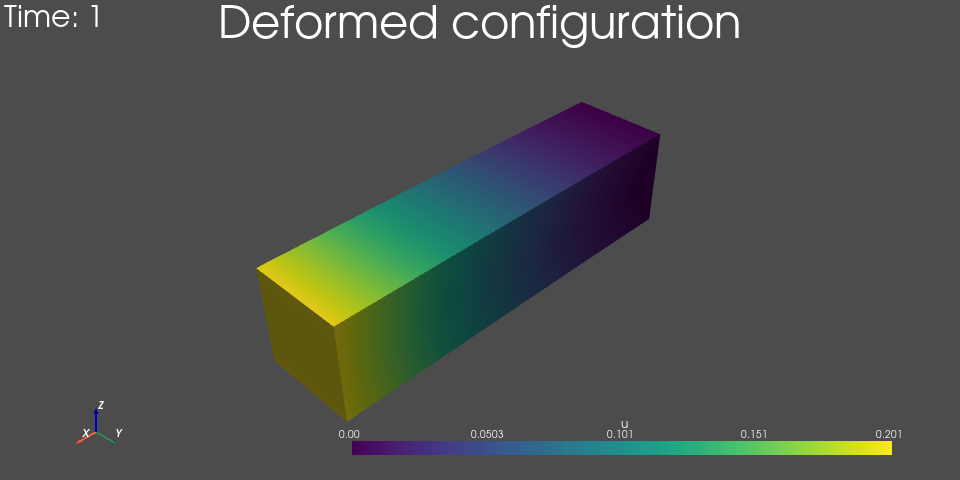

2021-09-29 05:18:26.278 ( 198.835s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:27.282 ( 199.839s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:27.927 ( 200.485s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.0350775 (tol = 1e-08) r (rel) = 0.00502244(tol = 1e-08)
2021-09-29 05:18:28.256 ( 200.814s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:28.811 ( 201.369s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 3.2397e-05 (tol = 1e-08) r (rel) = 4.63864e-06(tol = 1e-08)
2021-09-29 05:18:29.154 ( 201.712s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:29.836 ( 202.394s) [main            ]       NewtonSolver.cpp:36    INFO| Newton i

Time step 2, Number of iterations 4, Load [ 0.  0. -3.]


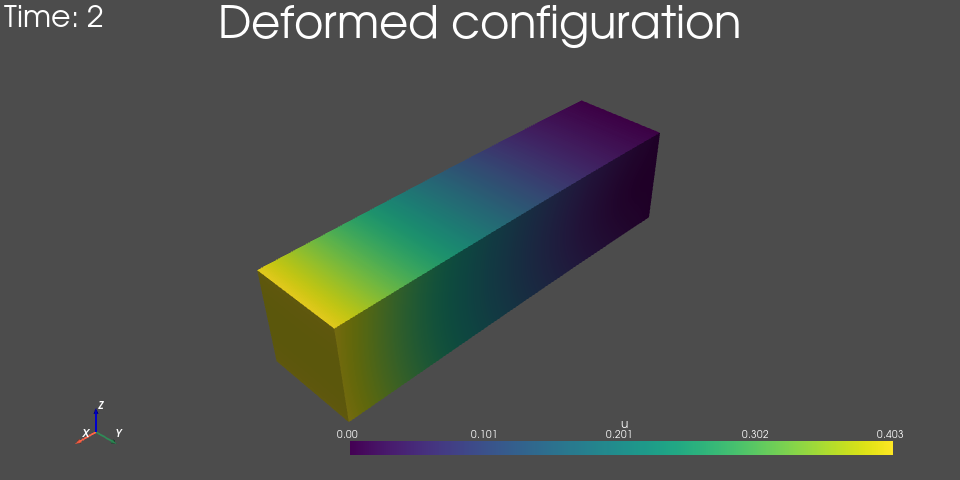

2021-09-29 05:18:30.589 ( 203.147s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:31.551 ( 204.109s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:32.120 ( 204.677s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.035114 (tol = 1e-08) r (rel) = 0.00503055(tol = 1e-08)
2021-09-29 05:18:32.426 ( 204.984s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:33.002 ( 205.560s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 6.27639e-05 (tol = 1e-08) r (rel) = 8.99178e-06(tol = 1e-08)
2021-09-29 05:18:33.342 ( 205.900s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:33.972 ( 206.530s) [main            ]       NewtonSolver.cpp:36    INFO| Newton i

Time step 3, Number of iterations 4, Load [ 0.   0.  -4.5]


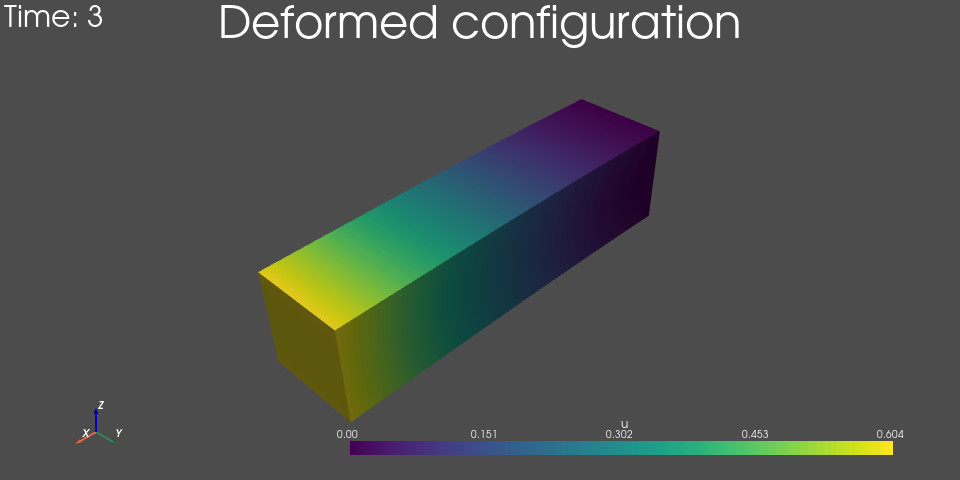

2021-09-29 05:18:34.704 ( 207.261s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:35.582 ( 208.140s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:36.157 ( 208.715s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.0351693 (tol = 1e-08) r (rel) = 0.00504328(tol = 1e-08)
2021-09-29 05:18:36.468 ( 209.026s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.


Time step 4, Number of iterations 4, Load [ 0.  0. -6.]


2021-09-29 05:18:37.030 ( 209.588s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 9.27769e-05 (tol = 1e-08) r (rel) = 1.33042e-05(tol = 1e-08)
2021-09-29 05:18:37.313 ( 209.871s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:37.853 ( 210.411s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 4: r (abs) = 2.1729e-10 (tol = 1e-08) r (rel) = 3.11594e-11(tol = 1e-08)
2021-09-29 05:18:37.853 ( 210.411s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 4 iterations and 4 linear solver iterations.


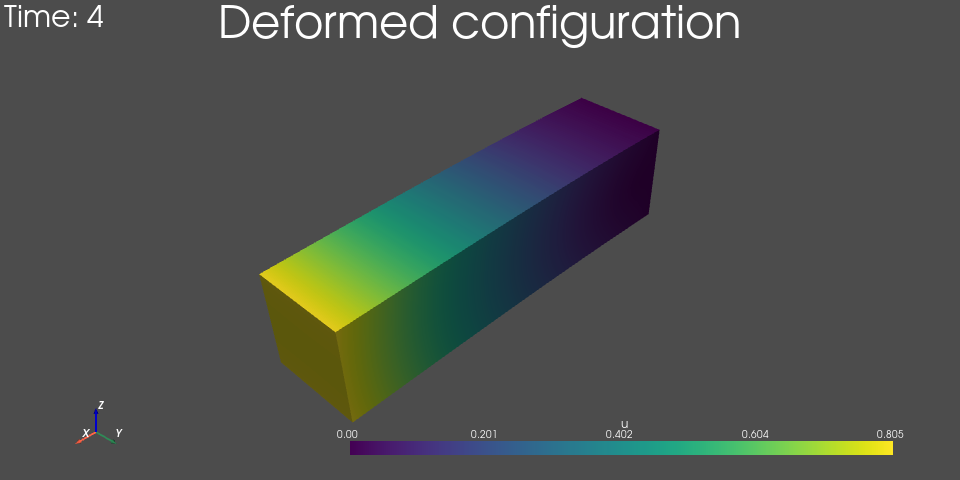

2021-09-29 05:18:38.503 ( 211.061s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:39.382 ( 211.940s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:39.956 ( 212.514s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.0352423 (tol = 1e-08) r (rel) = 0.00506047(tol = 1e-08)
2021-09-29 05:18:40.272 ( 212.830s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:40.844 ( 213.401s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 0.000122214 (tol = 1e-08) r (rel) = 1.75489e-05(tol = 1e-08)
2021-09-29 05:18:41.168 ( 213.726s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:41.835 ( 214.393s) [main            ]       NewtonSolver.cpp:36    INFO| Newton 

Time step 5, Number of iterations 4, Load [ 0.   0.  -7.5]


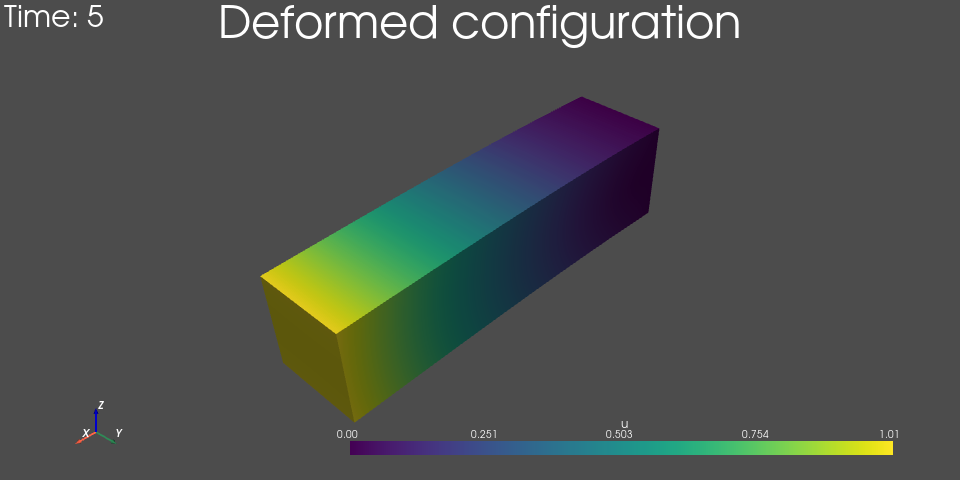

2021-09-29 05:18:42.566 ( 215.123s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:43.468 ( 216.025s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:44.090 ( 216.648s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.0353314 (tol = 1e-08) r (rel) = 0.00508195(tol = 1e-08)
2021-09-29 05:18:44.386 ( 216.944s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:44.959 ( 217.517s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 0.000150895 (tol = 1e-08) r (rel) = 2.17043e-05(tol = 1e-08)


Time step 6, Number of iterations 4, Load [ 0.  0. -9.]


2021-09-29 05:18:45.258 ( 217.816s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:45.848 ( 218.406s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 4: r (abs) = 3.45358e-10 (tol = 1e-08) r (rel) = 4.96751e-11(tol = 1e-08)
2021-09-29 05:18:45.848 ( 218.406s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 4 iterations and 4 linear solver iterations.


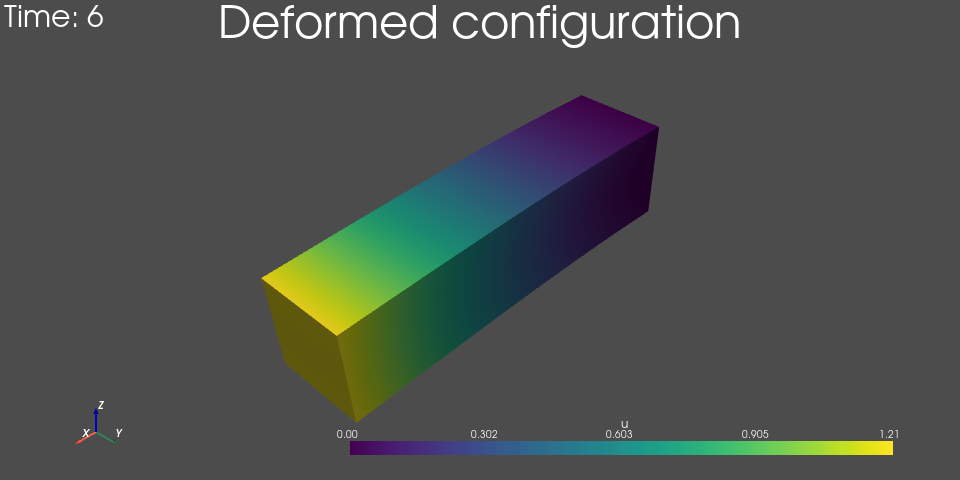

2021-09-29 05:18:46.594 ( 219.151s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:47.554 ( 220.111s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:48.181 ( 220.739s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.0354351 (tol = 1e-08) r (rel) = 0.00510748(tol = 1e-08)
2021-09-29 05:18:48.480 ( 221.038s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:49.113 ( 221.671s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 0.000178655 (tol = 1e-08) r (rel) = 2.57506e-05(tol = 1e-08)
2021-09-29 05:18:49.430 ( 221.988s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:50.001 ( 222.559s) [main            ]       NewtonSolver.cpp:36    INFO| Newton 

Time step 7, Number of iterations 4, Load [  0.    0.  -10.5]


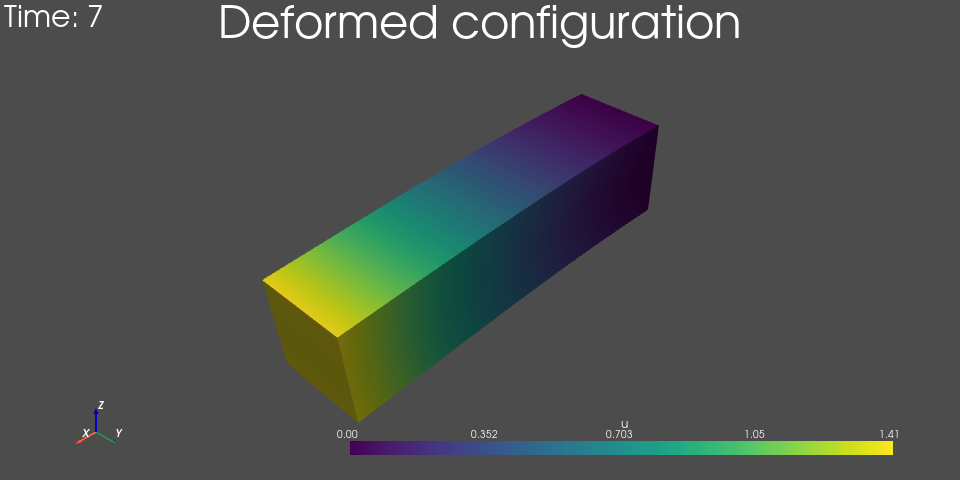

2021-09-29 05:18:50.630 ( 223.188s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:51.488 ( 224.046s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:52.098 ( 224.656s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.0355513 (tol = 1e-08) r (rel) = 0.0051368(tol = 1e-08)
2021-09-29 05:18:52.424 ( 224.982s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:53.011 ( 225.569s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 0.000205341 (tol = 1e-08) r (rel) = 2.96697e-05(tol = 1e-08)


Time step 8, Number of iterations 4, Load [  0.   0. -12.]


2021-09-29 05:18:53.323 ( 225.881s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:53.937 ( 226.495s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 4: r (abs) = 4.53691e-10 (tol = 1e-08) r (rel) = 6.55537e-11(tol = 1e-08)
2021-09-29 05:18:53.937 ( 226.495s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 4 iterations and 4 linear solver iterations.


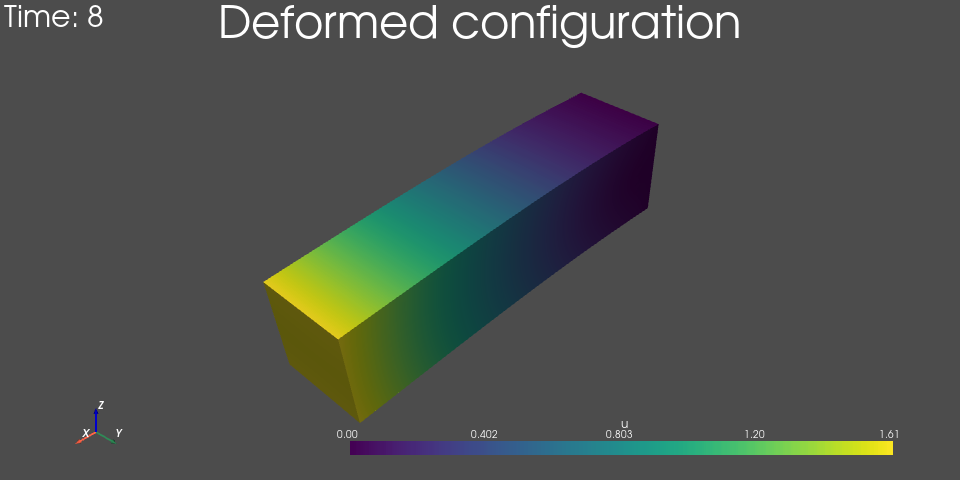

2021-09-29 05:18:54.662 ( 227.220s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:55.544 ( 228.102s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:56.062 ( 228.620s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.0356777 (tol = 1e-08) r (rel) = 0.0051696(tol = 1e-08)
2021-09-29 05:18:56.335 ( 228.893s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:56.870 ( 229.428s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 0.000230817 (tol = 1e-08) r (rel) = 3.34447e-05(tol = 1e-08)
2021-09-29 05:18:57.144 ( 229.701s) [main            ]  PETScKrylovSolver.cpp:98    INFO| PETSc Krylov solver starting to solve system.
2021-09-29 05:18:57.678 ( 230.236s) [main            ]       NewtonSolver.cpp:36    INFO| Newton i

Time step 9, Number of iterations 4, Load [  0.    0.  -13.5]


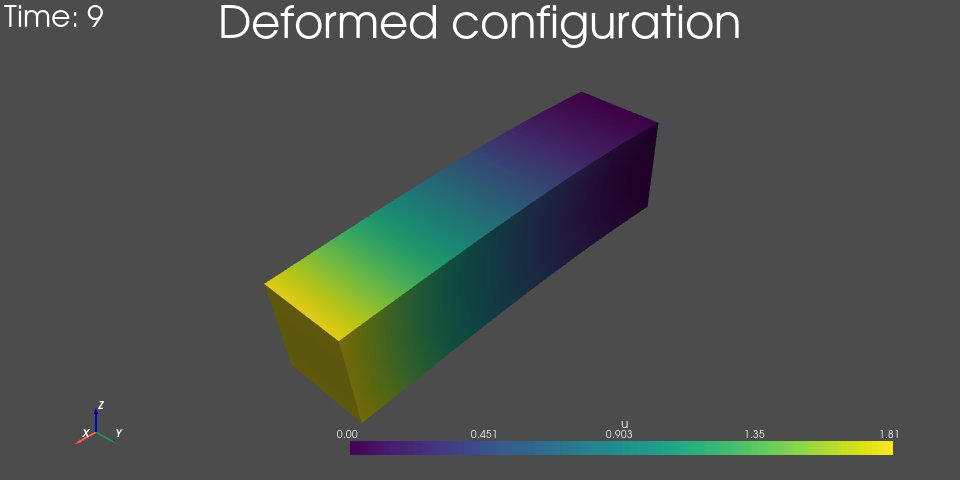

In [20]:
dolfinx.log.set_log_level(dolfinx.log.LogLevel.INFO)
tval0 = -1.5
for n in range(1, 10):
    T.value[2] = n * tval0
    num_its, converged = solver.solve(u)
    assert(converged)
    u.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    print(f"Time step {n}, Number of iterations {num_its}, Load {T.value}")
    plot_function(n, u)